In [2]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import datetime
# libreria para graficar velas
import plotly.graph_objects as go

plt.style.use('ggplot')
mpl.style.use("seaborn")
plt.rcParams['figure.figsize'] = (20,10)
# extra import for interactive plot!
from ipywidgets import interact
plt.rcParams['figure.figsize'] = (25,10)

### Python y API Binance

Primero s debe instalar la libreria con `pip install python-binance`


In [3]:
# Importando librerias de Binance

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager

In [16]:
# Definimos las credenciales para la authenticación
api_key="XBwBZYhuhmGGpF5qAzJXx7bX64Wh8sQBSoDkA4orYnSs5ttQ6i0nFuCxPOgoUjh9"
api_secret="YWV39SS9wgTJfVFmBN5mjS5QHfsiZ9l0XLEMDP3mreMgjNpIjuDKvYrT5aFYiNY7"

In [17]:
# Nos conectamos y generamos el cliente
client = Client(api_key, api_secret)


In [18]:
# Obtener todos los simbolos y precios
prices = client.get_all_tickers()

# Cantidad de precios
print("Cantidad de precios: {}".format(len(prices)))

# imprimimos los primeros 5
print("Primeros 5 elementos: ")
print(prices[:5])

# revisamos los que contienene ETH (Ethereum) y USD
[x for x in prices if "ETHUSD" in x["symbol"]]

Cantidad de precios: 2097
Primeros 5 elementos: 
[{'symbol': 'ETHBTC', 'price': '0.07804400'}, {'symbol': 'LTCBTC', 'price': '0.00276200'}, {'symbol': 'BNBBTC', 'price': '0.01335600'}, {'symbol': 'NEOBTC', 'price': '0.00045400'}, {'symbol': 'QTUMETH', 'price': '0.00193900'}]


[{'symbol': 'ETHUSDT', 'price': '1736.02000000'},
 {'symbol': 'ETHUSDC', 'price': '1736.49000000'},
 {'symbol': 'ETHUSDP', 'price': '1735.64000000'}]

## Obteniendo los klines

Basado en la [documentación de la REST API de binance](https://github.com/binance/binance-spot-api-docs/blob/master/rest-api.md#klinecandlestick-data), para la información de los klines, cada registro contiene el siguiente formato:

```json
[
  [
    1499040000000,      // Kline open time
    "0.01634790",       // Open price
    "0.80000000",       // High price
    "0.01575800",       // Low price
    "0.01577100",       // Close price
    "148976.11427815",  // Volume
    1499644799999,      // Kline Close time
    "2434.19055334",    // Quote asset volume
    308,                // Number of trades
    "1756.87402397",    // Taker buy base asset volume
    "28.46694368",      // Taker buy quote asset volume
    "0"                 // Unused field, ignore.
  ]
]
```
Cómo podemos abservar, el tiempo de apertura, precio  apertura, máximo, mínimo y cierre , se enceuntran en las 
columnas 0,1,2,3 y 4.

El formato de tiempo es un Unix Time.

En el siguiente ejemplo obtenemos los valores de un dia a cada minuto al la fecha de hoy.

In [19]:
print(1499644799999/100)
print(int(1499644799999/100))
print(round(1499644799999/100))

14996447999.99
14996447999
14996448000


In [6]:
klines_minute_1day = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1MINUTE, "1 day ago UTC")

In [15]:
# Analizaremos registro 1

print("registro 1  = ", klines_minute_1day[0])

columns = ["open_time","open","high","low","close","volume","close_time","quote_asset_volume","trades_count",
"taker_buy_base_asset_volume","taker_buy_quote_asset_volume","unused"]

open_time = datetime.datetime.fromtimestamp(klines_minute_1day[0][0]/1000, datetime.timezone.utc)
open_time_UTC_m7 = open_time - datetime.timedelta(hours=7)
close_time = datetime.datetime.fromtimestamp(klines_minute_1day[0][6]/1000, datetime.timezone.utc)

print("Tiempo apertura:",open_time.strftime("%d/%m/%Y %H:%M:%S"))
print("Tiempo apertura TZ-7:",open_time_UTC_m7.strftime("%d/%m/%Y %H:%M:%S"))
print("Tiempo cierre:",close_time.strftime("%d/%m/%Y %H:%M:%S"))

registro 1  =  [1662124920000, '1642.94000000', '1644.17000000', '1641.17000000', '1641.18000000', '1194.03740000', 1662124979999, '1961359.85678600', 1812, '705.43590000', '1158775.12150300', '0']
Tiempo apertura: 02/09/2022 13:22:00
Tiempo apertura TZ-7: 02/09/2022 06:22:00
Tiempo cierre: 02/09/2022 13:22:59


In [25]:
def timestamp2dt(time_stamp:int, tz_hour_dif:int=-7) -> datetime.datetime:
    """Convierte timestamp a datetime utilizando zona de tiempo"""
    dt = datetime.datetime.fromtimestamp(time_stamp/1000, datetime.timezone.utc)
    delta_hour = datetime.timedelta(hours=abs(tz_hour_dif))
    if tz_hour_dif == 0:
        return dt
    elif tz_hour_dif < 0:
        return dt - delta_hour
    else:
        return dt + delta_hour

In [27]:
# probando la funcón
timestamp2dt(klines_minute_1day[0][0]).strftime("%d/%m/%Y %H:%M:%S")

'02/09/2022 06:22:00'

Obtenemos los valores con intervalo de 30 minutos para el último mes de Agosto 2022

In [29]:
klines_30minutes_August2022 = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_30MINUTE, "1 August, 2022", "1 September, 2022")

# print top 5
klines_30minutes_August2022[:5]

[[1659312000000,
  '1678.12000000',
  '1687.41000000',
  '1672.63000000',
  '1686.26000000',
  '21541.06230000',
  1659313799999,
  '36135996.64728400',
  21783,
  '10850.75080000',
  '18207039.33824500',
  '0'],
 [1659313800000,
  '1686.25000000',
  '1690.58000000',
  '1681.54000000',
  '1688.31000000',
  '8122.44240000',
  1659315599999,
  '13705901.04291900',
  13013,
  '4315.20110000',
  '7281981.81040000',
  '0'],
 [1659315600000,
  '1688.32000000',
  '1699.08000000',
  '1683.76000000',
  '1697.23000000',
  '11994.72990000',
  1659317399999,
  '20268180.44215100',
  14933,
  '6334.19910000',
  '10706463.18901300',
  '0'],
 [1659317400000,
  '1697.22000000',
  '1697.87000000',
  '1691.71000000',
  '1696.74000000',
  '7077.25620000',
  1659319199999,
  '11999189.87046100',
  11387,
  '3503.24720000',
  '5939722.97388200',
  '0'],
 [1659319200000,
  '1696.74000000',
  '1704.68000000',
  '1693.26000000',
  '1697.51000000',
  '10229.02260000',
  1659320999999,
  '17365699.14531000',
  

Obtenemos datos semanales desde que está listado (ETHUSDT)

In [31]:
klines_weekly_all = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1WEEK, "1 Jan, 2017")

In [32]:
# print top 2
klines_weekly_all[:2]

[[1502668800000,
  '301.13000000',
  '312.18000000',
  '278.00000000',
  '299.10000000',
  '21224.89324000',
  1503273599999,
  '6376472.29413210',
  14013,
  '17401.68830000',
  '5241738.30398570',
  '0'],
 [1503273600000,
  '299.10000000',
  '348.13000000',
  '144.21000000',
  '348.13000000',
  '45233.88589000',
  1503878399999,
  '14567413.97749310',
  42362,
  '17326.14006000',
  '5564163.03804730',
  '0']]

# Graficando serie de tiempo en velas japonesas

Primero debemos preparar los datos y transformarlos en un dataframe, utilizaremos las columnas ya identificadas.

In [47]:
df = pd.DataFrame(klines_weekly_all, columns=columns)

In [48]:
df.head()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades_count,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,unused
0,1502668800000,301.13000000,312.18000000,278.00000000,299.10000000,21224.89324000,1503273599999,6376472.29413210,14013,17401.68830000,5241738.30398570,0
1,1503273600000,299.10000000,348.13000000,144.21000000,348.13000000,45233.88589000,1503878399999,14567413.97749310,42362,17326.14006000,5564163.03804730,0
2,1503878400000,348.11000000,394.39000000,320.08000000,341.77000000,33886.41427000,1504483199999,12290734.08941820,35671,11020.64303000,4002945.64036210,0
3,1504483200000,339.29000000,344.55000000,235.55000000,293.50000000,35485.23332000,1505087999999,10710999.66284450,33803,17117.15948000,5150514.59499200,0
4,1505088000000,293.51000000,316.46000000,192.00000000,257.55000000,58259.63439000,1505692799999,14998281.40081560,44796,23594.05524000,6122996.35882500,0


In [49]:
df["open_time"] = pd.to_datetime(df["open_time"]/1000, unit="s")
df["close_time"] = pd.to_datetime(df["close_time"]/1000, unit="s")

In [41]:
df.head()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,trades_count,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,unused
0,2017-08-14,301.13000000,312.18000000,278.00000000,299.10000000,21224.89324000,2017-08-20 23:59:59.999000064,6376472.29413210,14013,17401.68830000,5241738.30398570,0
1,2017-08-21,299.10000000,348.13000000,144.21000000,348.13000000,45233.88589000,2017-08-27 23:59:59.999000064,14567413.97749310,42362,17326.14006000,5564163.03804730,0
2,2017-08-28,348.11000000,394.39000000,320.08000000,341.77000000,33886.41427000,2017-09-03 23:59:59.999000064,12290734.08941820,35671,11020.64303000,4002945.64036210,0
3,2017-09-04,339.29000000,344.55000000,235.55000000,293.50000000,35485.23332000,2017-09-10 23:59:59.999000064,10710999.66284450,33803,17117.15948000,5150514.59499200,0
4,2017-09-11,293.51000000,316.46000000,192.00000000,257.55000000,58259.63439000,2017-09-17 23:59:59.999000064,14998281.40081560,44796,23594.05524000,6122996.35882500,0


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2017-08-14 to 2022-08-29
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   open                          264 non-null    object        
 1   high                          264 non-null    object        
 2   low                           264 non-null    object        
 3   close                         264 non-null    object        
 4   volume                        264 non-null    object        
 5   close_time                    264 non-null    datetime64[ns]
 6   quote_asset_volume            264 non-null    object        
 7   trades_count                  264 non-null    int64         
 8   taker_buy_base_asset_volume   264 non-null    object        
 9   taker_buy_quote_asset_volume  264 non-null    object        
 10  unused                        264 non-null    object        
dtypes: datetime64

In [74]:
numeric_columns = ["open", "high", "low", "close","volume","quote_asset_volume","taker_buy_base_asset_volume","taker_buy_quote_asset_volume"]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2017-08-14 to 2022-08-29
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   open                          264 non-null    float64       
 1   high                          264 non-null    float64       
 2   low                           264 non-null    float64       
 3   close                         264 non-null    float64       
 4   volume                        264 non-null    float64       
 5   close_time                    264 non-null    datetime64[ns]
 6   quote_asset_volume            264 non-null    float64       
 7   trades_count                  264 non-null    int64         
 8   taker_buy_base_asset_volume   264 non-null    float64       
 9   taker_buy_quote_asset_volume  264 non-null    float64       
 10  unused                        264 non-null    object        
dtypes: datetime64

In [59]:
df.set_index('open_time', inplace=True)

## Gráfica de velas de ETHUSDT desde 2017-08-14 a la fecha 

In [57]:
# Utilizando la lbrerya de mplfinance
import mplfinance as fplt

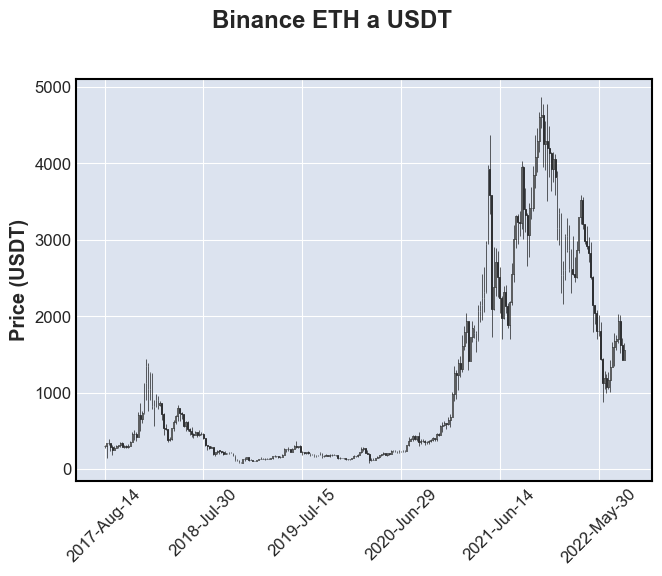

In [80]:
fplt.plot(
            df,
            type='candle',
            title='Binance ETH a USDT',
            ylabel='Price (USDT)'
        )

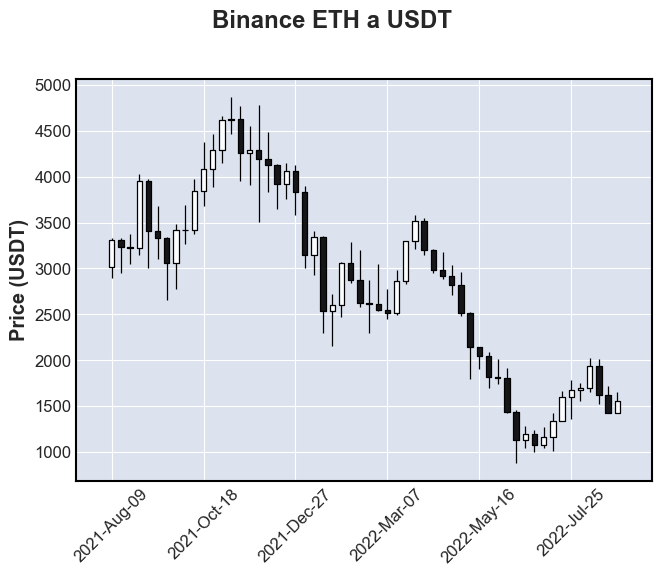

In [84]:
# Zoom a los ultimos datos
fplt.plot(
            df[-56:],
            type='candle',
            title='Binance ETH a USDT',
            ylabel='Price (USDT)'
        )

La libreria de `mplfinance` tiene varios estilos, los siquientes son los disponible

In [85]:
fplt.available_styles()

['binance',
 'blueskies',
 'brasil',
 'charles',
 'checkers',
 'classic',
 'default',
 'ibd',
 'kenan',
 'mike',
 'nightclouds',
 'sas',
 'starsandstripes',
 'yahoo']

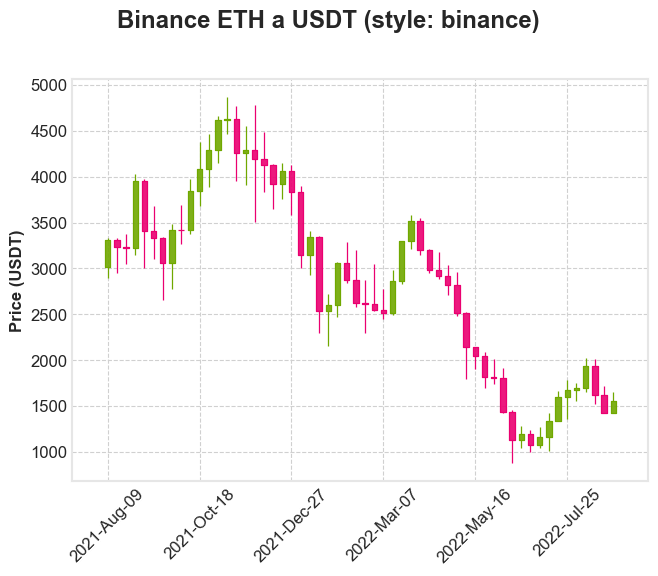

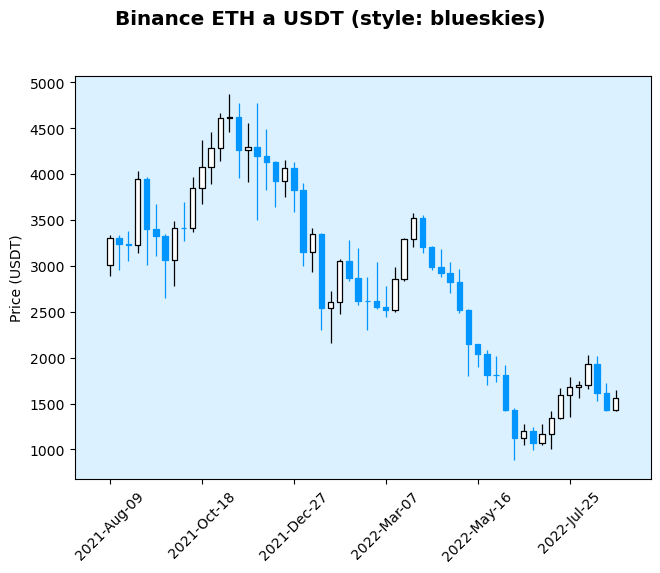

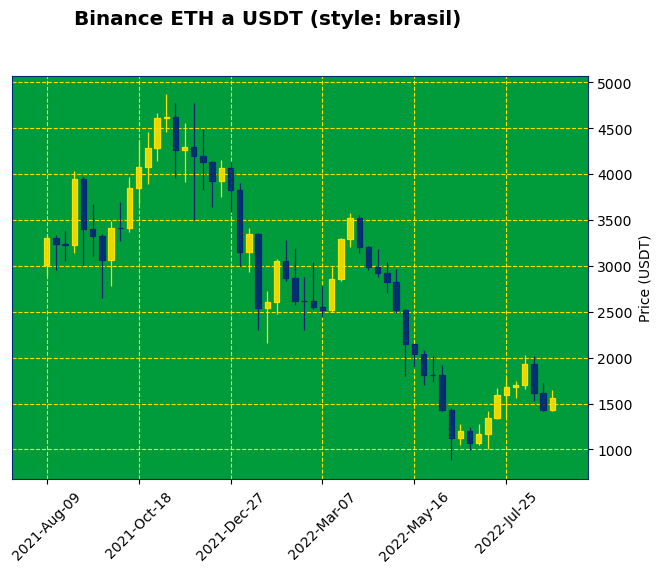

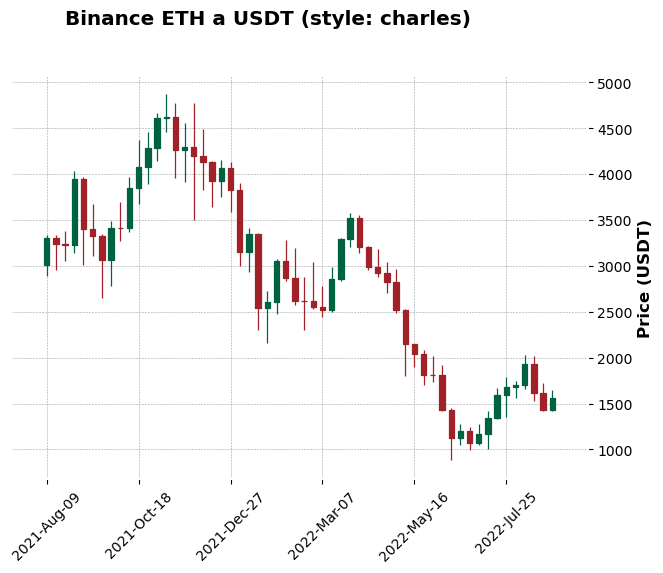

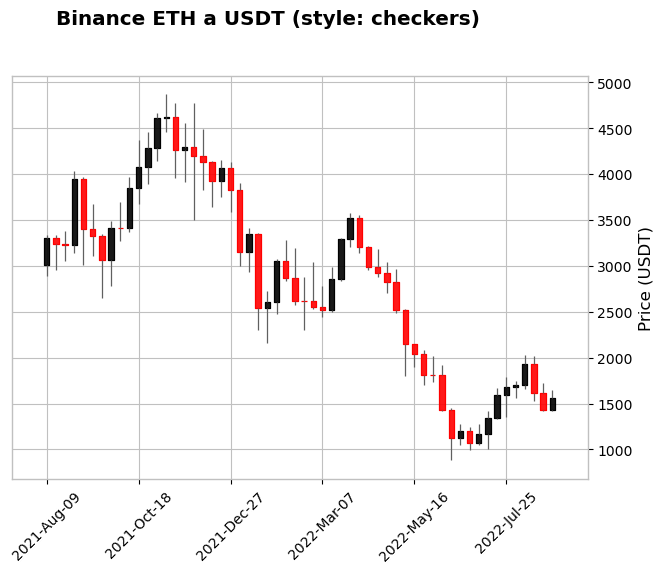

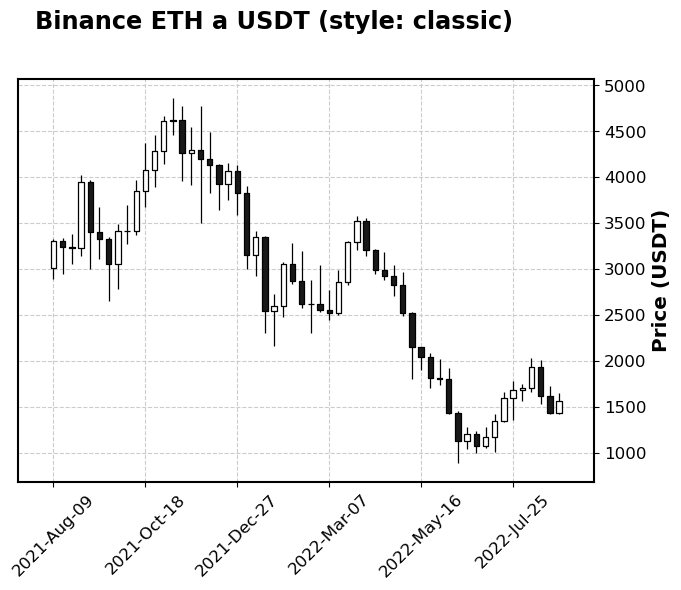

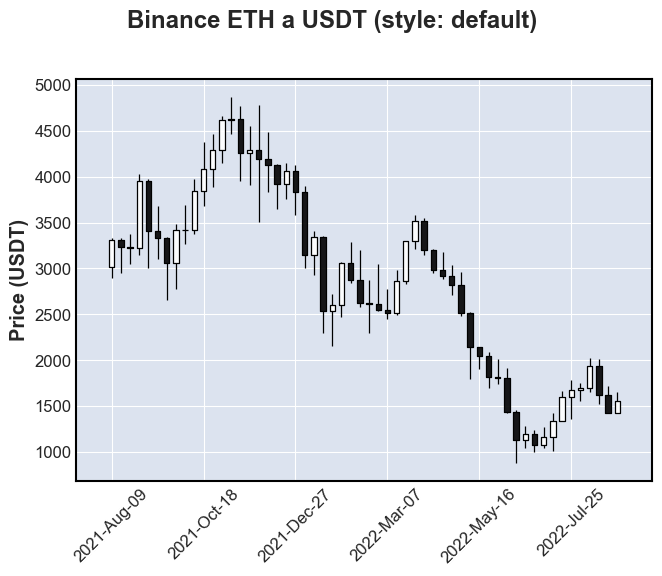

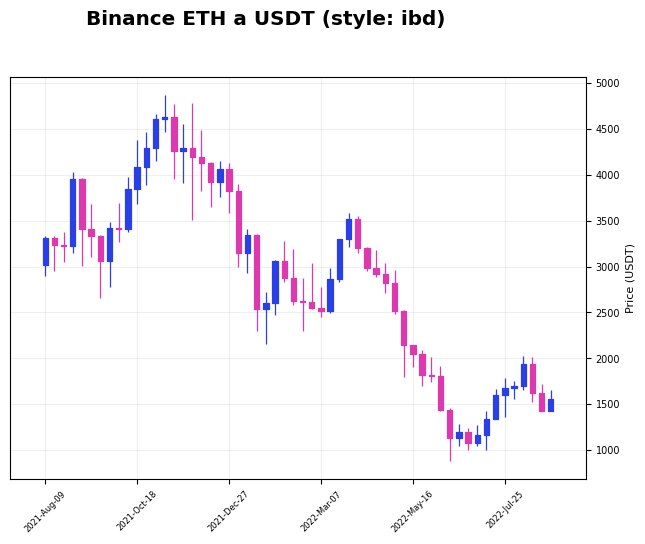

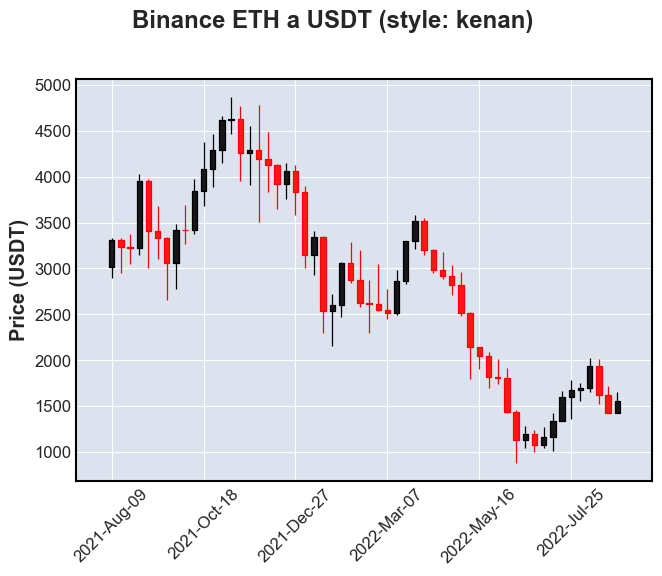

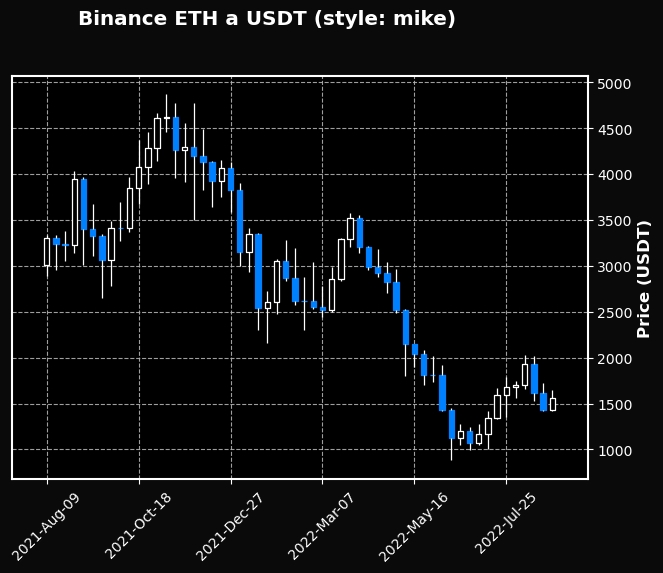

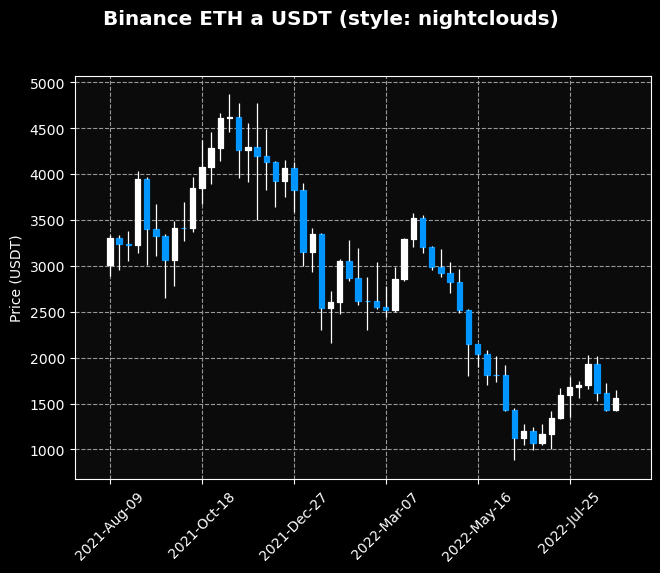

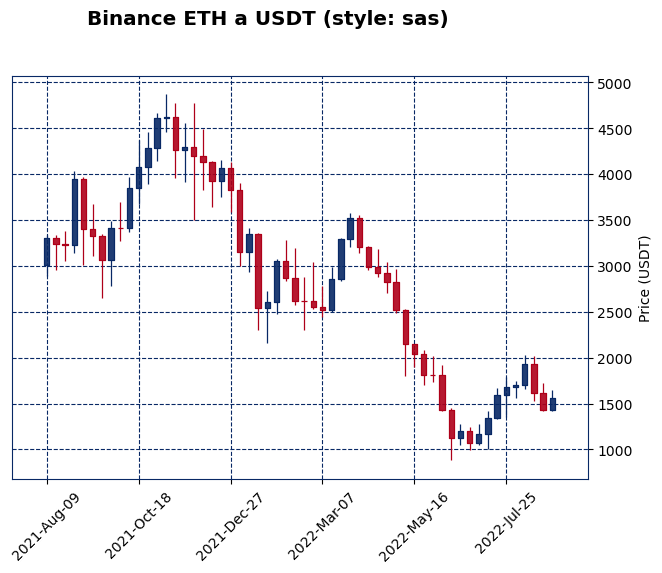

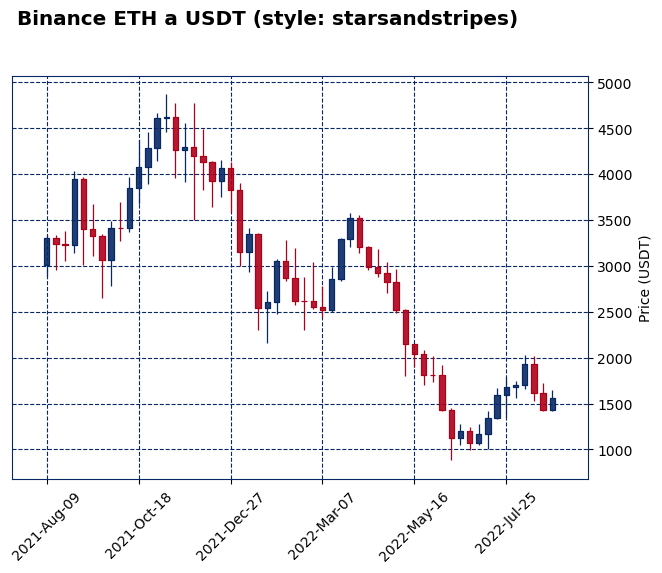

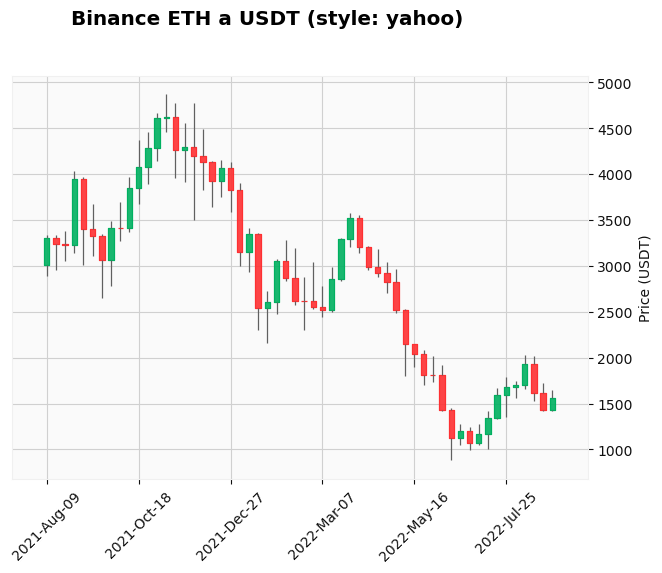

In [89]:
for style in fplt.available_styles():
    fplt.plot(
            df[-56:],
            type='candle',
            style=style,
            title='Binance ETH a USDT (style: {})'.format(style),
            ylabel='Price (USDT)'
        )


Agregaremos volumen a la gáfica

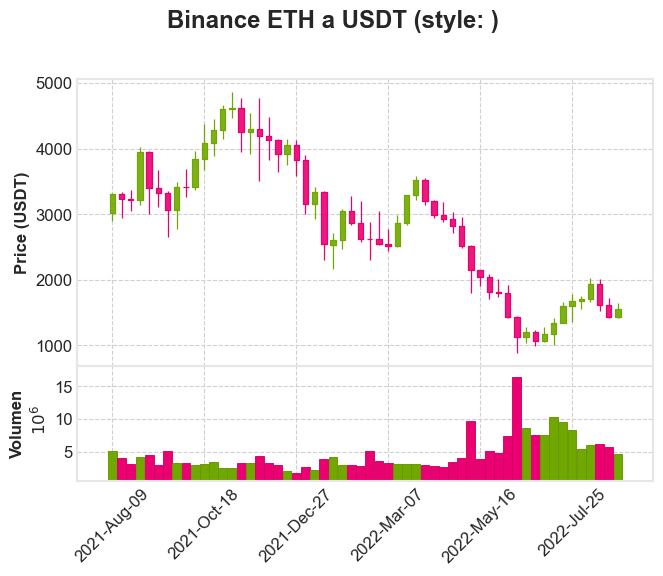

In [95]:
fplt.plot(
    df[-56:],
    type='candle',
    style='binance',
    title='Binance ETH a USDT (style: )',
    ylabel='Price (USDT)',
    volume=True,
    ylabel_lower='Volumen'
)

Tambien podemos habilitar que muestre los eventos que no hubo trading.

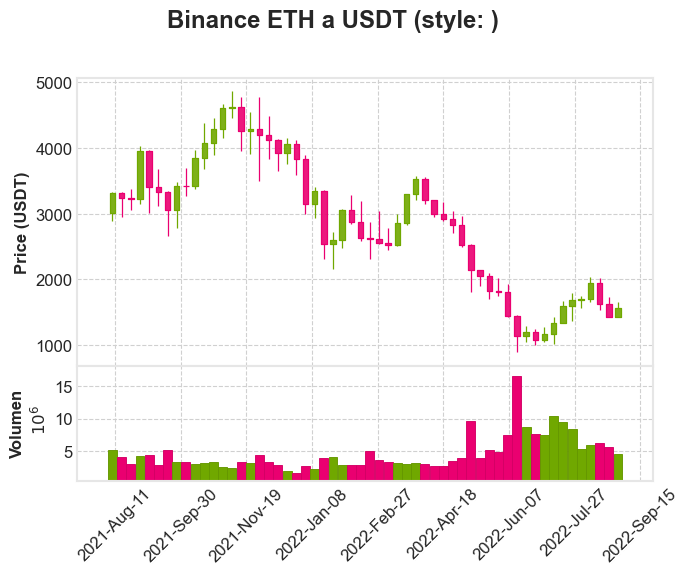

In [102]:
fplt.plot(
    df[-56:],
    type='candle',
    style='binance',
    title='Binance ETH a USDT (style: )',
    ylabel='Price (USDT)',
    volume=True,
    ylabel_lower='Volumen',
    show_nontrading=True
)

Ponemos el estylo final que utilizaremos para nuestra gáfica

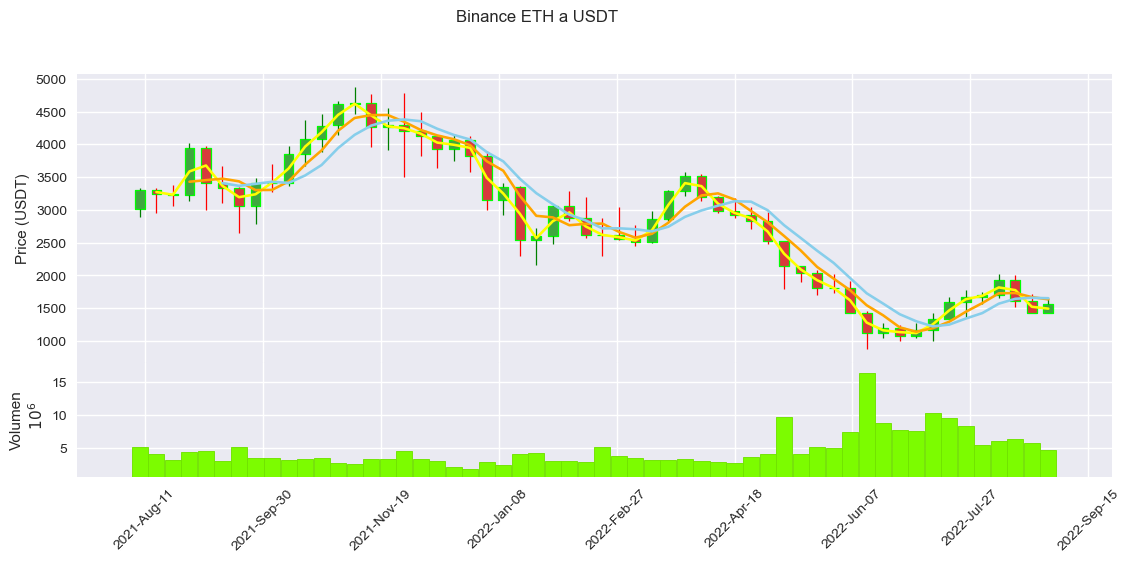

In [125]:
mc = fplt.make_marketcolors(
                            up='tab:green',down='tab:red',
                            edge='lime',
                            wick={'up':'green','down':'red'},
                            volume='lawngreen',
                           )

s  = fplt.make_mpf_style(base_mpl_style="seaborn", 
        marketcolors=mc, 
        mavcolors=["yellow","orange","skyblue"] # colors for Moving Average lines
    )
fplt.plot(
    df[-56:],
    type='candle',
    style=s,
    title='Binance ETH a USDT',
    ylabel='Price (USDT)',
    volume=True,
    ylabel_lower='Volumen',
    show_nontrading=True,
    figratio=(25,10),
    mav=(2,4,6)                   # Movinf average value
)

### Graficando con libreria plotly

In [120]:
# Initialization
import plotly.graph_objects as go
import plotly.io as pio
# to show available renders
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'vscode'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [121]:
# Render configuration
pio.renderers.default = "notebook_connected"

In [130]:
x = df.index[-56:]
candlestick = go.Candlestick(
                #x=pd.to_datetime(df['open_time']).dt.date,
                x=x,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])
fig = go.Figure(data=[candlestick])
fig.update_layout(
    title="Binance ETH a USDT",
    yaxis_title="Price (USDT)"
)
mva_line = go.Scatter(x=x, y=df["open"], mode="lines", name="MVA")
fig.add_trace(mva_line)
fig.show()

## Estrategias de trading mediante análisis técnico

El análisis técnico es una técnica de evaluación utilizada por los traders para predecir las fluctuaciones de los precios
en los mercados financieros. A diferencia del análisis fundamental, que se centra en fundamentos subyacentes como 
crecimiento de los ingresos y las tendencias de la industria, el análisis técnio se basa puramente en el análisis
estadístico de la lectura de gráficos, principalmente gráficas financiera en series de tiempo (líneas, velas japonesas, barras, etc).

El análisis técnico trata de predecir el precio futuro de un activo subyacente utilizando tanto los precios del pasado como los
volúmenes de trading.

La mayoría de las estrategias de análisis técnicos consisten en filtros y desencadenantes comerciales que se basan en diversos 
indicadores de análisis técnico.


- **Filtro de comercio** : indentifica las condiciones de configuración.
- **Disparadores de comercio**: identifican un momento determinado en el que se ejecuta una acción.

Estrategias a largo plazo -> medias moviles tendrá sentido

Esttrategia a corto plazo -> concentraci'on en indicadores de volatilidad.

Puntos a tomar en cuenta al elaborar una estrategia de análisis ténico:

- Tipo de media móvil que se utilice.
- Cuánto por encima o por debajo de la media móvil debe fluctuar un precio para entrar o salir de una posición.
- Qué tipo de órden se debe hacer cuandio se cumplen las condiciones del mercado.
- Cuántos contratos o acciones comprar/vender.
- Cuáles son las reglas de salida.


## Crossover de medias móviles

Se rastrea cómo dos medias móviles de diferente tamaño, reaccionan a las fluctuaciones de los precios. Por ejemplo, si se tiene
una media móvil de 50 dias y otra de 200, la estrategia **crossover** entrará en juego cuando la media móvil mas pequeña
(la de 50 días) creuce la media movil mas grande (la de 200 días). EL cruce indica una tendencia de precios al alza, lo que indica que es el momento de buscar oportunidad de compra. La ampliacion de la brechaentre la media pequeña y la grande después del cruce, afirma la fuerza de la **tendencia alcista emergente**.


In [ ]:
klines_daily_all = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1DAY, "1 Jan, 2017")

Por el contrario, la media móvil pequeña que atraviesa a la media movil grande desde arriba señala un desarrollo de una 
**tendencia a la baja**. La ampliación de la brecha entre las dos medias móviles en esa dirección afirma la fuerza
de la **tendencia descendente emergente**, lo que significa que debería tratar de vender.

### Referencias

- https://invezz.com/es/cursos/acciones/trading-de-acciones/estrategia-basica-del-analisis-tecnico/
